![](./header-logo.png)

## *Research Title*

**Automated and Connected Driving Challenges - Research Project - *MM/YYYY***

**Research Topic *14: Simulation-Based Performance Study of Semantic Image Segmentation***

*Note that you may alter the original research title if you find one more fitting for your work.*

| Author | Mail |
| --- | --- |
| Shengyao Jiang| shengyao.jiang@rwth-aachen.de |
| *insert here* | *insert here* |
| *insert here* | *insert here* |

*Note that we encourage you to work as a group, but of course you can also do the project on your own.*

#### Dependencies & Setup

##### Execution Environment

*Give more details for setting up your exeuction environment, if required. It is also helpful to give a rough estimate on how long the notebook takes to complete on your computer hardware that should also be mentioned then.*

##### Downloads

*Provide links and descriptions of any external data that should be downloaded, if required. Include information on where to place the downloaded files.*

##### Dependencies

*Below you can find a Jupyter notebook code cell showcasing how to install Python dependencies via pip directly inside the notebook. It is also possible to install other system dependencies (e.g., for ROS).*

In [2]:
# === INSTALLATION OF PYTHON DEPENDENCIES ==========================

import sys

# --- installation via pip -----------------------------------------

# install packages via pip (version numbers should be included to guarantee reproducibility)
!{sys.executable} -m pip install \
    bagpy~=0.5 \
    matplotlib~=3.4.3 \
    numpy~=1.22.3 \
    opencv-python~=4.6.0.66 \
    tqdm~=4.62.1

# === INSTALLATION OF OTHER SYSTEM DEPENDENCIES ====================
# Note that these may require admin privileges.
# You can pipe the password to 'sudo' by echoing it and running 'sudo -S', see below.

# --- installation of system dependencies via apt ------------------
!echo "jovyan" | sudo -S apt update
!echo "jovyan" | sudo -S apt install -y ros-noetic-sensor-msgs

# --- installation of ROS dependencies via rosdep ------------------
# !rosdep install -y --ignore-src --from-paths src

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 http://packages.ros.org/ros/ubuntu focal InRelease                       
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease                     
Hit:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease             
Hit:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu focal-security InRelease33m
Reading package lists... Done
Building dependency tree       
Reading state information... Done
168 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ros-noetic-sensor-msgs is already the newest version (1.13.1-1focal.20221124.030802).
0 upgraded, 0 newly installed, 0 to remove and 168 not upgraded.


*At this point you should already import the Python packages required for the code cells in this report.*

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import rosbag
#from tqdm.notebook import tqdm
from tqdm import tqdm
from IPython.display import display, Image

#### Abstract

*Most scientific papers start with a short so-called Abstract. An abstract is short summary of your research paper, usually just one paragraph long with fewer than ten sentences. It serves the purpose of giving the reader a chance to quickly understand the essence of the research. Due to the sheer amount of public research, oftentimes the abstract is where readers decide whether it is worthwhile to read the full paper or not.*

*Below, the report is structured into sections Introduction, Related Work, Methodology, Experiments, Evaluation, and Conclusion. This is a common structure in scientific papers. The purpose of each section is explained in the section blocks below. Please note that this structure is not a hard constraint; you may alter it, if reasonable.*

### Introduction

Perception is an important component of an autonomous driving system, which refers to the ability of an autonomous driving system to perceive its surroundings through various sensors, including recognizing and understanding elements such as roads, vehicles, pedestrians, and obstacles. Based on different sensors and different stages of data processing, the automatic driving perception task can be divided into several sub-tasks, such as semantic segmentation, target detection, motion pattern recognition, etc., thus providing a basis for the system's planning and control decisions. "The goal of semantic segmentation is to segment the input image according to semantic information and predict the semantic category of each pixel from a given label set." [[1]](https://www.sciencedirect.com/science/article/pii/S0925231222000054)。Depending on the sensor, semantic segmentation is mainly categorized into LiDAR-based semantic segmentation and vision-based semantic segmentation,this article is concerned with visual semantic segmentation. As with many machine learning methods, vision-based semantic segmentation methods also face the problem of domain shift. Domain shift refers to the phenomenon where the data distribution used to train a machine learning model differs from the data distribution encountered during actual application (testing). This distribution discrepancy can cause the model to perform well on the training set but experience a decline in performance when applied in real-world scenarios. Typical problems caused by domain shift in autonomous driving scenarios are, for example, that a model trained in a rural scenario does not perform well in an urban scenario, and that a classifier trained in a sunny scenario does not perform well in a rainy scenario.

Although researchers seem to agree on the concept of domain shift, due to the complexity of the display world, it is not possible to be as precise in describing every domain as in describing mathematical distributions.In reality many domains do not have clear boundaries between them and are intertwined. For example, driving from the center of the city to the edge of the city, the surrounding scene changes gradually rather than suddenly. Therefore we raise two questions:

- a) Is there some kind of “correlation” from one domain to another? To be more specific, the relationship between rural, small town, and urban is a progressive one in terms of the concept of urbanization. If model A is trained in countryside scenarios, it can be hypothesized that it tends to perform poorly in the test set of small town and city scenarios. If model B performs well in the training set with only countryside and city, can model B outperform the countryside in the small town test set? Does a model trained on the sunny and rainy day training sets perform better in cloudy day scenarios than a model trained in sunny day only scenarios?*

- b) If the answer to question a) is “yes”, can we determine some kind of optimal domain partitioning before training a model for autonomous driving so that the amount of data required to train a compliant model is minimized?*

Currently many autonomous driving companies collect their own datasets in order to train autonomous driving algorithms, the vast majority of which are kept strictly confidential. There are some companies that publish their own datasets, such as Waymo Open Dataset [[2]](https://openaccess.thecvf.com/content_CVPR_2020/html/Sun_Scalability_in_Perception_for_Autonomous_Driving_Waymo_Open_Dataset_CVPR_2020_paper.html) from Waymo and ApolloScape [[3]](https://openaccess.thecvf.com/content_cvpr_2018_workshops/w14/html/Huang_The_ApolloScape_Dataset_CVPR_2018_paper.html) from Baidu. These datasets often require a large amount of manual labeling of the dataset, which entails a high economic cost, and the training process also often consumes a lot of energy and generates carbon emissions, which also creates a burden for the environment. We The author believes that researching the questions raised in the previous paragraphs can provide a basis for the generation of datasets and the scale of model training to overcome the domain shift for autonomous driving models, in order to achieve the purpose of saving the economic and environmental costs.

This paper discuss mainly about the question a). We first generate two datasets A and B by controlling domain variables such as city, weather, number of pedestrians, number of vehicles, etc. where the generation of dataset A is based on the smaller values of the domain variables and the generation of dataset B is based on the smaller and larger values of the domain variables. Then we train models with the same structure on each of the two datasets. Finally we test the performance of the two models on new datasets which are generated based on the intermediate values and out-of-distribution values of the domain variables. After compare the resultls, we draw the conclusion:


to be continued
.............

### Related Work

To deal with the problem of domain shift, researchers have proposed many approaches, and there are two main types of approaches,domain adaption and domain generalization. 

Domain adaptation refers to the process of training a model on a source domain, and whenever the model needs to be applied to a target domain with a distribution different from that of the source domain, the model is adapted to learn the distribution of the target domain. When the lable of the target domain is available, one of the most direct and mature solutions is probably fine-tuning, so current research on domain adaptation mainly focuses on the case where the lable of the target domain is not available. For the case where the target domain is not obtainable, unsupervised learning and adversarial methods have gained more attention. Yang etl. [[4]](https://openaccess.thecvf.com/content_ECCV_2018/html/Yang_Zou_Unsupervised_Domain_Adaptation_ECCV_2018_paper.html) proposed a self-training with self-paced learning adaptation framework for segmentation, which achieve state-of-the-art performance in vision-based semantic segmentation. Vu etl. [[5]](https://openaccess.thecvf.com/content_CVPR_2019/html/Vu_ADVENT_Adversarial_Entropy_Minimization_for_Domain_Adaptation_in_Semantic_Segmentation_CVPR_2019_paper.html) proposed a entropy-minimization-based adversarial training approach which is also one of the state-of-the-art approaches.

Different from domain adaptation, what domain generalization mainly does is to learn a generic feature representation from multiple well-labeled source domain data, and hope that the representation can also be applied to unseen similar samples. Thus domain generalization hopes to get the result that the model can be trained only once to achieve good performance in different target domains. The main difference with domain adaptation is whether the model uses data from the target domain during training. Li etl. [[6]](https://openaccess.thecvf.com/content/CVPR2021/html/Li_Semantic_Segmentation_With_Generative_Models_Semi-Supervised_Learning_and_Strong_Out-of-Domain_CVPR_2021_paper.html)propose a generative model, which is probaly the first purely generative method modeling he joint image-label distribution and performs strong generalization in vision-based semantic segmentation task. Lee etl. [[7]](https://openaccess.thecvf.com/content/CVPR2022/html/Lee_WildNet_Learning_Domain_Generalized_Semantic_Segmentation_From_the_Wild_CVPR_2022_paper.html)proposed a content and style extention learning method in their model, which also gain good generalization performance.


Good deep learning studies are based on precisely labeled datasets. Faced with the problem that manually labeled data is usually slow and costly, some synthetic datasets have been proposed. For example,GTA V Dataset [[8]](https://download.visinf.tu-darmstadt.de/data/from_games/)，and SYNTHIA Dataset [[9]](https://ieeexplore.ieee.org/document/7780721)。In particularly, Sun et al. [[10]](https://openaccess.thecvf.com/content/CVPR2022/papers/Sun_SHIFT_A_Synthetic_Driving_Dataset_for_Continuous_Multi-Task_Domain_Adaptation_CVPR_2022_paper.pdf) designed the SHIFT dataset specifically for domain adaptation research in the field of autonomous driving。In difference to the dataset mentioned above, Geller et al. proposed the CARLOS framework [[11]](https://ieeexplore.ieee.org/document/10588502). CARLOS can quickly generate datasets with multi specified domain variables according to the users' needs, providing a high degree of freedom in dataset generation for researchers in domain shift field.


### Methodology

#### a) *Data genaration and annotation*
We first built a new docker image based on the original image provided by CARLOS and modified a part of the code so that the new image contains maps for rural (Town07) and highway (Town06) inside.
For the specific process please check [How to add the extra maps into carlos.md](./How_to_add_the_extra_maps_into_carlos.md). We generated rosbag data packages using CARLOS's data-driven development use case. Each rosbag data package contains a stream of time-synchronized rgb camera images as well as a stream of groudtruth semantic map. Then we extracted the images from the image stream through a [python script](./extract_images.ipynb), aligned them according to the timestamps, and saved them in the directory structure required for training and validation.

#### b) *Data preprocessing*

#### c) *Deep learning model*

#### d) *Evaluation matrices and result visualization*
In order to evaluate the performanc of the models on different datasets, we chose to Mean Intersection over Union (mIoU) and confidence score as evaluation metrics. Where mIoU is a metric that measures the average overlap between the predicted regions and the ground truth regions, providing an overall assessment of the model's performance across the entire dataset or all categories. Below is the mIoU‘s formula,
$$
\text{mIoU} = \frac{1}{N} \sum_{i=1}^{N} \frac{\text{True Positive}_i}{\text{True Positive}_i + \text{False Positive}_i + \text{False Negative}_i}
$$

where N denotes the number of the class. And confidence score is the probability value corresponding to the predicted category, i.e., the maximum probability value output by the softmax function. Below is the confidence score formula,
$$
\text{Confidence} = \max(\text{softmax}(z))
$$
where $z$ denotes the logits output for each pixel (raw value without softmax)

We calculated the mIoU in image level and dataset level. Confidence score is the maximum softmax probility which is directly obtained from the model's output.  To visualize the confidence score for each pixel point in each image, we mapped the confidence value to gray scale vaues as follows. The darker a pixel is, the closer the class confidence is to 0, and the brighter a pixel is, the closer the class confidenceis to 1. Thus we obtain a "confidence image", shown below

![confidence image](./images/confidence2.png)

CARLOS provides a result visualization demo script, based on which we changed a portion of the code to run the city maps we wanted. We developed an evaluation node based on ika-rwth-aachen [acdc library](https://github.com/ika-rwth-aachen/acdc). The evaluation node relys on ROS2 and runs inside a docker container created on [rwthika/ros2-tf:humble-desktop-full-tf2.11.0](https://hub.docker.com/layers/rwthika/ros2-tf/humble-desktop-full-tf2.11.0/images/sha256-769be7ad1eece5ccb6e455926fd11e93964b05778fe413b47786885de9538a6f?context=explore) provided by rwth ika. To run the evaluation node please check [How to run a evaluation demo.md](./How_to_run_a_evaluation_demo.md). For evaluation node's source code please check [evaluation.py](./colcon_ws/src/evaluation_node/evaluation_node/evaluation.py) and [image_segmentation.py](colcon_ws/src/image_segmentation_r2/image_segmentation_r2/image_segmentation.py). For container construction please check [Dockerfile](./docker-clion/Dockerfile).



*"Before the input images are fed to the neural network training algorithm, each image is pre-processed in the following way: first, an image is converted to grayscale; second, uniform noise is applied to the image; then ... ."*

In [4]:
def preprocessImage(img: np.ndarray) -> np.ndarray:

    # convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # apply uniform noise
    MAX_NOISE = 50
    noise = np.random.randint(-MAX_NOISE, MAX_NOISE, img.shape)
    img = img.astype(np.int16) + noise      # avoid under/overflow
    img = img.clip(0, 255).astype(np.uint8) # clip to 0-255

    # ...

    return img

*"One exemplary pre-processing output is shown below, alongside the original input image."*

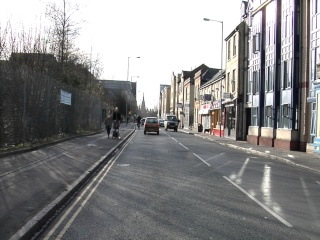

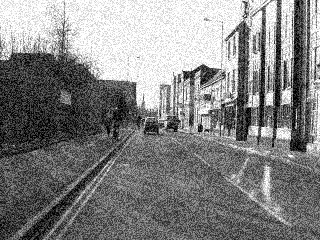

In [7]:
# define helper to visualize np-images in notebook
def displayImage(img: np.ndarray):
    display(Image(cv2.imencode(".jpg", img)[1]))

# load example image
example_img_filepath = "demo.tiff"
example_img = cv2.imread(example_img_filepath)

# preprocess example image
preprocessed_example_img = preprocessImage(example_img)

# show original and preprocessed image
displayImage(example_img)
displayImage(preprocessed_example_img)

*Even if your code is not executable in the Jupyter notebook, either because it belongs to a Python ROS node or because it is written in C++, you can still present it in this section. Such code is best included as a formatted Markdown code block. Specific parts of a Python ROS node may even be extracted to an executable code cell. If code is not executable, please only include code components relevant to the current section. Below you can find an example of how to present non-executable source code such as Python/C++ ROS nodes.*

*"In order to ..., a ROS node (shown below) publishes the same image with a frequency of 1Hz."*

```py
import cv2
import rospy
from sensor_msgs.msg import Image


class ImagePublisher:

    def __init__(self):

        rospy.init_node("ImagePublisher")
        self.setup()

    def setup(self):

        # load image
        img_filepath = rospy.get_param("~img_filepath")
        img = cv2.imread(img_filepath)

        # convert image to ROS message
        self.msg = self.bridge.cv2_to_imgmsg(img, "bgr8")

        # create publisher
        self.pub = rospy.Publisher("~image", Image)

        # create timer to publish image each second
        self.timer = rospy.Timer(rospy.Duration(1), self.publishImage)

    def publishImage(self):

        self.pub.publish(msg)
```

### Experiments

#### a) *Design of train and validation datasets*
We train two models with the same structure on two different train datasets. The two training sets are named “single dataset” and “multi dataset”. Finally, both models are evaluated on the validation dataset. These three datasets' domian varialble values are: 


| #| single dataset | multi dataset |validation dataset|
| ---| --- | --- |---|
| <b>Weather</b>| ClearNoon | ClearSunset, ClearNoon, MidRainySunset, MidRainyNoon | SoftRainNoon, HardRainySunset, CloudySunset, WetNoon  |
| <b>Town</b>| Rural| Town07(Rural)<br></br> <br>Town10(Downtown)</br>| Town02(small town)<br> <br>Town03(urban map with a roundabout and large junctions)</br> <br>Town05(Squared-grid town with cross junctions and a bridge)</br>, <br>Town06(highway)</br>   |
| <b>Vehicle-Occupacy</b>| 0.2(less vehicle)| 0.2, 0.8(many vehicle)| 0.1，0.3，0.5，0.7  |
| <b>Walker number</b>| 50| 50, 200|  100，150，250，350 |







Both models are trained on single dataset and multi dataset for 200 epochs using the same initialization values, random number seed, learning rate, batch size and other hyperparameters.

"*Before training the neural network, the entire dataset has to be pre-processed.*"

In [9]:
from tqdm import tqdm#maybe the correct way to import tqdm https://github.com/CosmiQ/solaris/issues/392
# define dataset location
files = ["demo.tiff"] * 100

# load entire dataset into memory
images = [cv2.imread(f) for f in files]
print(f"Loaded {len(images)} images")

# preprocess all images
preprocessed_images = []
for img in tqdm(images, desc="Preprocessing images"):
    prep_img = preprocessImage(img)
    preprocessed_images.append(prep_img)
print(f"Preprocessed {len(preprocessed_images)} images")

Loaded 100 images


Preprocessing images: 100%|██████████| 100/100 [00:00<00:00, 1437.65it/s]

Preprocessed 100 images


*Since ROS nodes and C++ code cannot be directly executed within the Jupyter notebook, please instead report the commands required to run your experiments in those cases. Make sure that the commands are executable in your presented execution environment. See the example below.*

*"After compilation of the ROS workspace, first the image publishing node has to be launched."*

```bash
catkin build -DCMAKE_BUILD_TYPE=Release
```

```bash
rosrun my_package image_publisher.py
```

### Evaluation

*One of the most important parts of any piece of research is the impartial presentation, evaluation, and discussion of its experimental results, including the limitations of the methodology used to arrive at these results. Here, quantitative and qualitative results can be presented in the overall context of the research. Interesting observations may justify special attention in detailed analyses. It is also possible to compare to related works of research here.*

*This section should also contain code cells supporting the evaluation. Taking the experimental outputs from the previous section, here, quantitative metrics can be computed, plots can be created, and qualitative outputs can be presented. Some examples can be found below.*

*"In order to reason about ..., the mean pixel values of the pre-processed images are plotted below."*

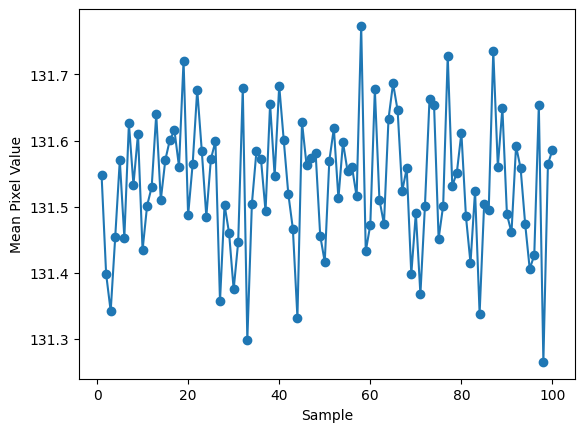

In [10]:
# define metric
def evaluatePreprocessedImage(img: np.ndarray) -> float:

    return np.mean(img)

# compute metrics of preprocessed images
prep_metrics = [evaluatePreprocessedImage(img) for img in preprocessed_images]

# plot metrics
plt.xlabel("Sample")
plt.ylabel("Mean Pixel Value")
plt.plot([i+1 for i in range(len(preprocessed_images))], prep_metrics, "-o")

*Note that Python code for evaluation may also be a good way to analyze and discuss the experiment results from some non-Python implementations. If dealing with ROS nodes, you could, e.g., have the code commands in the Experiments section record a ROS bagfile, which you then read with the [rosbag Python API](http://wiki.ros.org/rosbag/Code%20API#Python_API) and evaluate the contents in executable Jupyter notebook cells. One example is shown below.*

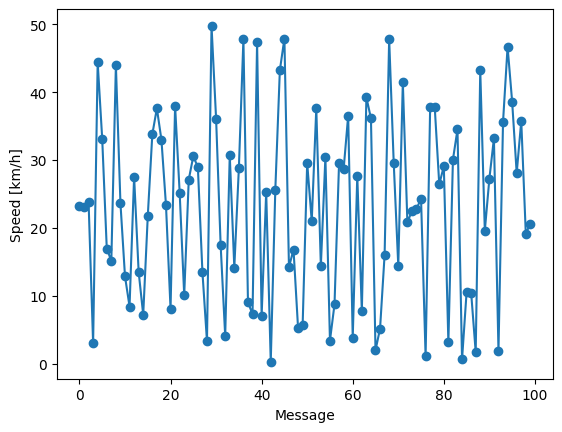

In [12]:
# read all messages from rosbag
msgs = {}
for topic, msg, t in rosbag.Bag("demo.bag").read_messages():
    if topic not in msgs:
        msgs[topic] = []
    msgs[topic].append(msg)

# plot speed
speeds = [msg.data for msg in msgs["/speed"]]
plt.xlabel("Message")
plt.ylabel("Speed [km/h]")
plt.plot(speeds, "-o")

### Conclusion

*As the final building block of the report, the contents and results of the research should be summarized. The conclusion often also includes a short outlook on future research motivated through the one at hand.*

#### References

*The list of references lists further information about all work that has been cited. Please make sure to hyperlink all references.*

| # | Year | Authors | Title |
| --- | --- | --- | --- |
| 1| 2022 | Y Mo, Y Wu, X Yang, F Liu, Y Liao| [Review the state-of-the-art technologies of semantic segmentation based on deep learning](https://www.sciencedirect.com/science/article/pii/S0925231222000054) |
| 2| 2020 | Pei Sun, Henrik Kretzschmar, Xerxes Dotiwalla, Aurelien Chouard, Vijaysai Patnaik, Paul Tsui, James Guo, Yin Zhou, Yuning Chai, Benjamin Caine, Vijay Vasudevan, Wei Han, Jiquan Ngiam, Hang Zhao, Aleksei Timofeev, Scott Ettinger, Maxim Krivokon, Amy Gao, Aditya Joshi, Yu Zhang, Jonathon Shlens, Zhifeng Chen, Dragomir Anguelov| [Scalability in Perception for Autonomous Driving: Waymo Open Dataset](https://openaccess.thecvf.com/content_CVPR_2020/html/Sun_Scalability_in_Perception_for_Autonomous_Driving_Waymo_Open_Dataset_CVPR_2020_paper.html) |
| 3| 2018 | Xinyu Huang, Xinjing Cheng, Qichuan Geng, Binbin Cao, Dingfu Zhou, Peng Wang, Yuanqing Lin, Ruigang Yang| [The ApolloScape Dataset for Autonomous Driving](https://openaccess.thecvf.com/content_cvpr_2018_workshops/w14/html/Huang_The_ApolloScape_Dataset_CVPR_2018_paper.html) |
| 4| 2018 | Yang Zou, Zhiding Yu, B.V.K. Vijaya Kumar, Jinsong Wang| [Unsupervised Domain Adaptation for Semantic Segmentation via Class-Balanced Self-Training](https://openaccess.thecvf.com/content_ECCV_2018/html/Yang_Zou_Unsupervised_Domain_Adaptation_ECCV_2018_paper.html) |
| 5| 2018 | Tuan-Hung Vu, Himalaya Jain, Maxime Bucher, Matthieu Cord, Patrick Perez| [ADVENT: Adversarial Entropy Minimization for Domain Adaptation in Semantic Segmentation](https://openaccess.thecvf.com/content_CVPR_2019/html/Vu_ADVENT_Adversarial_Entropy_Minimization_for_Domain_Adaptation_in_Semantic_Segmentation_CVPR_2019_paper.html) |
| 6| 2021 | Daiqing Li, Junlin Yang, Karsten Kreis, Antonio Torralba, Sanja Fidler| [Semantic Segmentation With Generative Models: Semi-Supervised Learning and Strong Out-of-Domain Generalization](https://openaccess.thecvf.com/content/CVPR2021/html/Li_Semantic_Segmentation_With_Generative_Models_Semi-Supervised_Learning_and_Strong_Out-of-Domain_CVPR_2021_paper.html) |
| 7| 2021 | Suhyeon Lee, Hongje Seong, Seongwon Lee, Euntai Kim| [WildNet: Learning Domain Generalized Semantic Segmentation From the Wild](https://openaccess.thecvf.com/content/CVPR2022/html/Lee_WildNet_Learning_Domain_Generalized_Semantic_Segmentation_From_the_Wild_CVPR_2022_paper.html) |
| 8| 2016 | Stephan R. Richter, Vibhav Vineet, Stefan Roth, Vladlen Koltun | [Playing for Data: Ground Truth from Computer Games](https://download.visinf.tu-darmstadt.de/data/from_games/) |
| 9| 2016 | German Ros, Laura Sellart, Joanna Materzynska, David Vazquez, Antonio M. Lopez | [The SYNTHIA Dataset: A Large Collection of Synthetic Images for Semantic Segmentation of Urban Scenes](https://ieeexplore.ieee.org/document/7780721) |
| 10| 2022 | Tao Sun, Mattia Segu, Janis Postels, Yuxuan Wang, Luc Van Gool, Bernt Schiele, Federico Tombari, Fisher Yu | [SHIFT: A Synthetic Driving Dataset for Continuous Multi-Task Domain Adaptation](https://openaccess.thecvf.com/content/CVPR2022/papers/Sun_SHIFT_A_Synthetic_Driving_Dataset_for_Continuous_Multi-Task_Domain_Adaptation_CVPR_2022_paper.pdf) |
| 11| 2024 | Christian Geller, Benedikt Haas, Amarin Kloeker, Jona Hermens, Bastian Lampe,Till Beemelmanns, Lutz Eckstein | [CARLOS: An Open, Modular, and Scalable Simulation Framework for the Development and Testing of Software for C-ITS](https://ieeexplore.ieee.org/document/10588502) |
